<div id= 'main'>
	<h1>Satellite Imagery Segmentation using U-Net</h1>
</div>

In [28]:
# !pip install keract

In [29]:
## local conda venv - gis3

import itertools as itools

import pandas as pd
import numpy as np
import pathlib

import geopandas as gpd
import geopandas as pdg
import shapely.geometry as shpy

import rasterio as rio
import rasterio.plot

import rasterio.plot as rioplot
import fiona 
from rasterio.mask import mask as riomask
from rasterio import warp as riowrap
from rasterio.warp import reproject as rioReproject
from patchify import patchify

import keras.layers as klyr
import keras.models as kmodel
import keras.backend as kerasb

import math, os
import random

import json

import matplotlib.pyplot as plt
plt.style.use( style= 'dark_background' )

import sklearn
import sklearn.preprocessing as skPreprocess
from sklearn import model_selection
# import contextily

import keras
import tensorflow as tf
print(  'Num GPUs Available: ', len( tf.config.list_physical_devices('GPU') )  )

import keract as kact

from keras import layers as klyr
import cv2
import PIL as pil

import os
os.environ[ 'SM_FRAMEWORK' ] = 'tf.keras'
import segmentation_models as seg_model

from pprint import pprint

%matplotlib inline
np.random.seed(1)

import wandb
from wandb.keras import WandbCallback as wb_Callback
import keras.layers as klyr
import keras.models as kmodel

from IPython.core.display import display, HTML
display(  HTML( '<style>.container { width:98% !important; }</style>' )  )

%config Completer.use_jedi = False

DIR_dataset = r'E:\Geospatial courses\notebooks\datasets'


Num GPUs Available:  1


/tmp/ipykernel_71429/1065874010.py:64: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<br> <hr> <br> <br>

## Reading & Preprocessing Satellite Images

In [30]:
# DIR_Dubai = r'E:/Geospatial-courses/notebooks/datasets/SemanticSegmentImagery-Dubai'
DIR_Dubai = r'/mnt/e/Geospatial-courses/notebooks/datasets/SemanticSegmentImagery-Dubai'

In [31]:
IMG_patchSz = 256

<br>

#### How does Scaling works in 3 dim np array?

<img src= 'images/sklearn_Scale_npArray.JPG' style= 'width:832px;height:618px;'>
<!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->

In [32]:
def scale_npArr( img1 ):
	## stack the 3 D np array into 2D
	img_STACKED = img1.reshape( -1, img1.shape[-1] )   ## (256, 256, 3) --> (65536, 3) 
	minMaxScaler_obj = skPreprocess.MinMaxScaler( )
	img_stacked_SCALED = minMaxScaler_obj.fit_transform( img_STACKED )
	## reshape into original shape
	img1_SCALED = img_stacked_SCALED.reshape( img1.shape )   ## (65536, 3) --> (256, 256, 3)

	return img1_SCALED

#### reshaping all the images to a fix shape.

In [33]:
## get paths for all the imgs
img_rootDir = pathlib.Path( DIR_Dubai )
imgPath_ls = [  str(efile) for efile in img_rootDir.rglob( '*.jpg' ) ]
lblPath_ls = [  str(efile) for efile in img_rootDir.rglob( '*.png' ) ]

## ---------------------------------------------- for imgs  ---------------------------------------------------
### for imgs
npArray_ls = [  cv2.imread(e_imgPath)  for e_imgPath in imgPath_ls  ]  ## convert image file into np array
_imgNpArr_ls = [   cv2.resize(  eNpArr, dsize= (IMG_patchSz,IMG_patchSz), interpolation= cv2.INTER_AREA  )\
            		for eNpArr in npArray_ls   ]
## min max scale
imgNpArr_ls = [  scale_npArr( e_imgNpArr )  for e_imgNpArr in _imgNpArr_ls  ]

In [34]:
## ---------------------------------------------- for lbl  ---------------------------------------------------
_lblNpArray_ls = [  cv2.imread(e_lblPath)  for e_lblPath in lblPath_ls  ] 
lbl_bgr2rgb_ls = [  cv2.cvtColor( e_NpArr, code= cv2.COLOR_BGR2RGB ) for e_NpArr in _lblNpArray_ls  ]  ## changing the BGR --> RGB, only for lbl data not for images
lblNpArr_ls = [   cv2.resize(  eNpArr, dsize= (IMG_patchSz,IMG_patchSz), interpolation= cv2.INTER_NEAREST  )\
            		for eNpArr in lbl_bgr2rgb_ls   ]

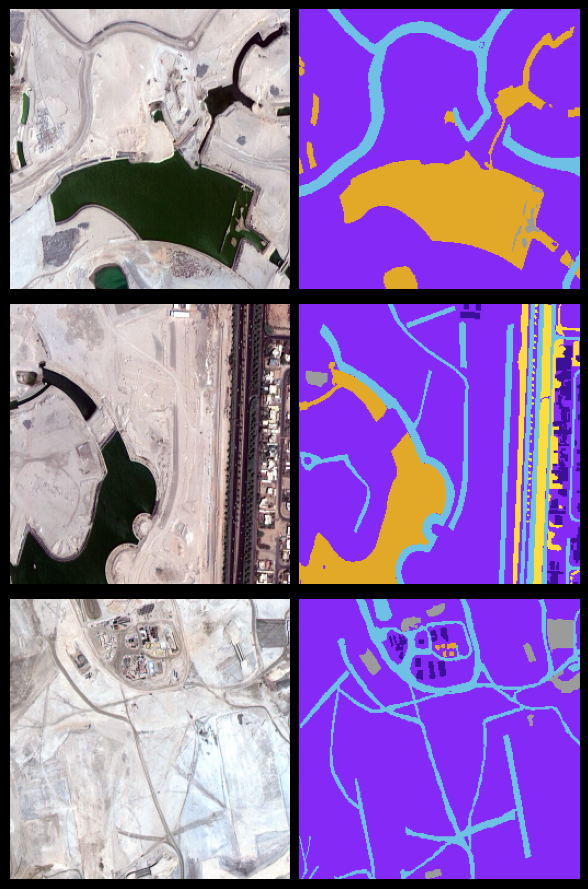

In [35]:
fg, ax = plt.subplots( 3, 2, figsize= (6, 9) )
idx1, idx2, idx3 = 1,2,3
ax[0][0].imshow(  imgNpArr_ls[idx1]  );   ax[0][1].imshow( lblNpArr_ls[idx1] )
ax[1][0].imshow(  imgNpArr_ls[idx2]  );   ax[1][1].imshow( lblNpArr_ls[idx2] )
ax[2][0].imshow(  imgNpArr_ls[idx3]  );   ax[2][1].imshow( lblNpArr_ls[idx3] )
[  eax.set_axis_off()  for eax in ax.flatten()  ];
fg.tight_layout()

#### reclassify hex values to 0 to 5

In [36]:
def hex_to_rgb(hex_value):
	"""Converts a hex color value to an RGB tuple.
	# example:  50E3C2	-->   [80, 227, 194]
	"""
	# return tuple(  int(hex_value[i:i+2], 16) for i in (1, 3, 5)  )
	return np.array(  [ int(hex_value[i:i+2], 16) for i in (1, 3, 5)  ] )

In [37]:
with open(  os.path.join( DIR_Dubai, 'classes.json' ), 'r' ) as f:
	class_dict = json.load(f)

class_df = (
	pd.DataFrame(  class_dict['classes']  )
	.filter( [ 'title', 'color' ] )
	.rename( columns= { 'color': 'color_hex' } )
	.assign(  color_rgb =  lambda df: df['color_hex'].apply(hex_to_rgb)  )
	.reset_index( drop= False, names= 'classLabel' )
)
print(class_df)

   classLabel                title color_hex        color_rgb
0           0                Water   #E2A929   [226, 169, 41]
1           1  Land (unpaved area)   #8429F6   [132, 41, 246]
2           2                 Road   #6EC1E4  [110, 193, 228]
3           3             Building   #3C1098    [60, 16, 152]
4           4           Vegetation   #FEDD3A   [254, 221, 58]
5           5            Unlabeled   #9B9B9B  [155, 155, 155]


In [38]:
list(  zip( class_df['color_rgb'], class_df['classLabel'] )  )

[(array([226, 169,  41]), 0),
 (array([132,  41, 246]), 1),
 (array([110, 193, 228]), 2),
 (array([ 60,  16, 152]), 3),
 (array([254, 221,  58]), 4),
 (array([155, 155, 155]), 5)]

In [39]:
colorMapDict = {  tuple(eRGBarr): eClasslbl\
                  for eRGBarr, eClasslbl in zip( class_df['color_rgb'], class_df['classLabel'] )  }
colorMapDict

{(226, 169, 41): 0,
 (132, 41, 246): 1,
 (110, 193, 228): 2,
 (60, 16, 152): 3,
 (254, 221, 58): 4,
 (155, 155, 155): 5}

In [40]:
# your_array = maskPatch_ls[5].copy()
## this map should have worked but there are '0' in some maskPatch_ls array so need to build try-catch for those erroneous np arr
# maskLbl_ls = list(   map(  lambda  xArr: np.apply_along_axis(  func1d= lambda eRgb: colorMapDict.get(tuple(eRgb)), axis= -1, arr= xArr  ), maskPatch_ls   )   )

lblArrReclass_ls =[]
for idx, e_npArr in enumerate( lblNpArr_ls ):
    try:
        lblArrReclass_ls.append(   np.apply_along_axis(  func1d= lambda eRgb: colorMapDict.get(tuple(eRgb)), axis= -1, arr= e_npArr  )   )
    except:
        lblArrReclass_ls.append(  np.full( shape= e_npArr.shape[:-1], fill_value= 5, dtype= np.int8 )  )  ## 5 is unlabelled; e_npArr.shape[:-1] = 256, 256

# ## convert None to 5 (unlabelled) in array, and dtype to int8
lblArrReclass_ls = list(    map(   lambda eArr: np.where( eArr == None, 5, eArr ), lblArrReclass_ls   )    )
lblArrReclass_ls = list(    map(   lambda eArr: np.array( eArr, dtype= np.int8 ), lblArrReclass_ls   )    )

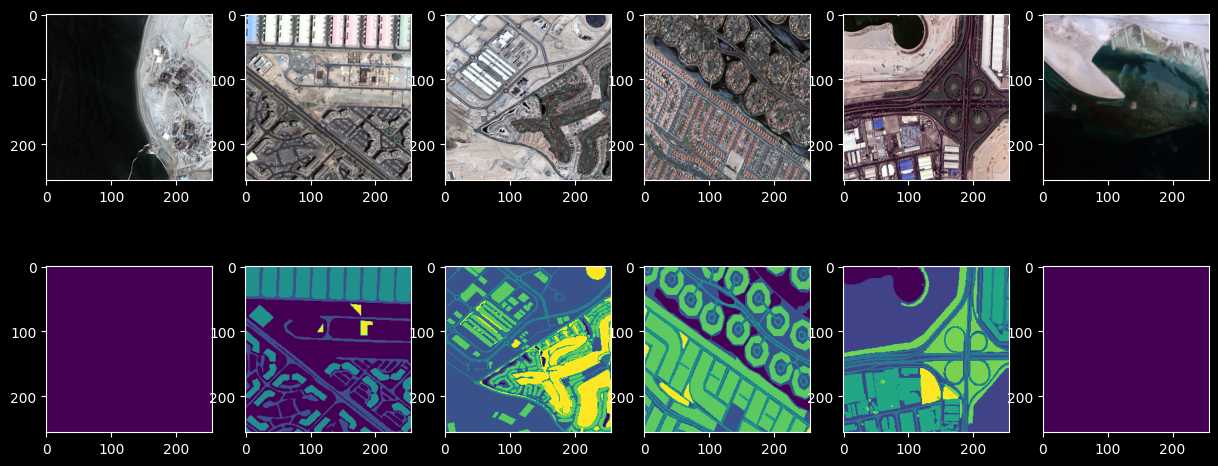

In [41]:
## visualize how imagery and corresponding masking looks

fg, ax = plt.subplots( 2, 6, figsize= (15,6) )
for idx, eAx in enumerate( ax.flatten()[:6] ):
    randInt = random.randint( 0, len(lblArrReclass_ls) )
    eAx.imshow(  imgNpArr_ls[randInt]  );
    ax.flatten()[idx+6] .imshow(  lblArrReclass_ls[randInt]  )
plt.show()

<br><br>

### Prep for Deep Learning

In [42]:
print( len(imgNpArr_ls), imgNpArr_ls[0].shape );  print( len(lblArrReclass_ls), lblArrReclass_ls[0].shape )

classTotal = len( np.unique(lblArrReclass_ls) )

72 (256, 256, 3)
72 (256, 256)


In [43]:
## ohe
lblOheArr_ls = list(    map(   lambda eArr: np.eye(classTotal)[ eArr - 1 ], lblArrReclass_ls   )    )    
print( f'{lblArrReclass_ls[0].shape}  -->  {lblOheArr_ls[0].shape}' )

(256, 256)  -->  (256, 256, 6)


In [44]:
## conver list of np arrays into a arr for ip into DNN
img_np = np.stack( imgNpArr_ls, axis= 0 )
lbl_np = np.stack( lblOheArr_ls, axis= 0 )
img_np.shape, lbl_np.shape

((72, 256, 256, 3), (72, 256, 256, 6))

In [45]:
xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split( img_np, lbl_np, test_size= 15./100, random_state= 10 )

In [46]:
print( xtrn.shape, xtst.shape, ytrn.shape, ytst.shape )

(61, 256, 256, 3) (11, 256, 256, 3) (61, 256, 256, 6) (11, 256, 256, 6)


###  Developing Neural Network

In [47]:
import keras.layers as klyr
import keras.models as kmodel

In [48]:
numClass = ytrn.shape[-1]
img_ht, img_wd, img_chn = xtrn.shape[1:]
img_ht, img_chn

(256, 3)

In [49]:
import keras.backend as kerasb

def jaccard_coef( yi, yhat ):
    _yi, _yhat =  kerasb.flatten( yi ), kerasb.flatten( yhat )  ## flattening ys
    intersection_ys = kerasb.sum( _yi * _yhat )
    iou_ys = ( intersection_ys + 1.0 ) / (  kerasb.sum(_yi) + kerasb.sum(_yhat) - intersection_ys + 1.0 )
    return iou_ys    

#### define neural network

## U NET

<img src= 'images/unet_dnn_handmarked.png' style= 'width:1058px;height:704px;'>
 <!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->

In [50]:
input_Tnsr = klyr.Input(  shape= ( img_ht, img_wd, img_chn )  )

conv_lyr1 = klyr.Conv2D(  filters= 16, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(input_Tnsr)
conv_lyr1 = klyr.Dropout( rate= 20/100 )( conv_lyr1 )
conv_lyr1 = klyr.Conv2D(  filters= 16, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr1)

mpool12 = klyr.MaxPooling2D( pool_size= 2 )( conv_lyr1 )

conv_lyr2 = klyr.Conv2D(  filters= 32, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(mpool12)
conv_lyr2 = klyr.Dropout( rate= 20/100 )( conv_lyr2 )
conv_lyr2 = klyr.Conv2D(  filters= 32, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr2)

mpool23 = klyr.MaxPooling2D( pool_size= 2 )( conv_lyr2 )

conv_lyr3 = klyr.Conv2D(  filters= 64, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(mpool23)
conv_lyr3 = klyr.Dropout( rate= 20/100 )( conv_lyr3 )
conv_lyr3 = klyr.Conv2D(  filters= 64, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr3)

mpool34 = klyr.MaxPooling2D( pool_size= 2 )( conv_lyr3 )

conv_lyr4 = klyr.Conv2D(  filters= 128, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(mpool34)
conv_lyr4 = klyr.Dropout( rate= 20/100 )( conv_lyr4 )
conv_lyr4 = klyr.Conv2D(  filters= 128, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr4)

mpool45 = klyr.MaxPooling2D( pool_size= 2 )( conv_lyr4 )

conv_lyr5 = klyr.Conv2D(  filters= 256, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(mpool45)
conv_lyr5 = klyr.Dropout( rate= 20/100 )(conv_lyr5)
conv_lyr5 = klyr.Conv2D(  filters= 256, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr5)

## Conv2DTranspose layer

upConv_lyr56 = klyr.Conv2DTranspose(  filters= 128, kernel_size= 2, strides= 2, padding= 'same'  )( conv_lyr5 )

deconv_lyr6 = klyr.concatenate(  [ upConv_lyr56 , conv_lyr4 ]  )
conv_lyr6 = klyr.Conv2D(  128, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(deconv_lyr6)
conv_lyr6 = klyr.Dropout( 20/100 )(conv_lyr6)
conv_lyr6 = klyr.Conv2D(  128, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr6)

upConv_lyr67 = klyr.Conv2DTranspose(   64, 2, strides= 2, padding= 'same'  )( conv_lyr6 )

deconv_lyr7 = klyr.concatenate(  [ upConv_lyr67, conv_lyr3 ]  )
conv_lyr7 = klyr.Conv2D(  64, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(deconv_lyr7)
conv_lyr7 = klyr.Dropout( 20/100 )( conv_lyr7 )
conv_lyr7 = klyr.Conv2D(  64, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr7)

upConv_lyr78 = klyr.Conv2DTranspose(   32, 2, strides= 2, padding= 'same'  )( conv_lyr7 )

deconv_lyr8 = klyr.concatenate(  [ upConv_lyr78, conv_lyr2 ]  )
conv_lyr8 = klyr.Conv2D(  32, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(deconv_lyr8)
conv_lyr8 = klyr.Dropout( 20/100 )( conv_lyr8 )
conv_lyr8 = klyr.Conv2D(  32, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr8)

upConv_lyr89 = klyr.Conv2DTranspose(   16, 2, strides= 2, padding= 'same'  )( conv_lyr8 )

deconv_lyr9 = klyr.concatenate(  [ upConv_lyr89, conv_lyr1 ]  )
conv_lyr9 = klyr.Conv2D(  16, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(deconv_lyr9)
conv_lyr9 = klyr.Dropout( 20/100 )( conv_lyr9 )
conv_lyr9 = klyr.Conv2D(  16, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr9)

output_Tnsr = klyr.Conv2D(  filters= numClass, kernel_size= 1, activation= 'softmax'  )(conv_lyr9)


## define model 

kerasModel1 = kmodel.Model(  inputs= [input_Tnsr], outputs= [output_Tnsr]  )

2024-04-11 02:07:11.999799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-11 02:07:11.999948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-11 02:07:12.000028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-11 02:07:12.774722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-11 02:07:12.775050: I external/local_xla/xla/stream_executor

In [51]:
## make a func out of the model

def multi_UnetModel( noClass, ht, wd, chn ):
	"""
	
	"""

	input_Tnsr = klyr.Input(  shape= ( ht, wd, chn )  )

	conv_lyr1 = klyr.Conv2D(  filters= 16, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(input_Tnsr)
	conv_lyr1 = klyr.Dropout( rate= 20/100 )( conv_lyr1 )
	conv_lyr1 = klyr.Conv2D(  filters= 16, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr1)

	mpool12 = klyr.MaxPooling2D( pool_size= 2 )( conv_lyr1 )

	conv_lyr2 = klyr.Conv2D(  filters= 32, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(mpool12)
	conv_lyr2 = klyr.Dropout( rate= 20/100 )( conv_lyr2 )
	conv_lyr2 = klyr.Conv2D(  filters= 32, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr2)

	mpool23 = klyr.MaxPooling2D( pool_size= 2 )( conv_lyr2 )

	conv_lyr3 = klyr.Conv2D(  filters= 64, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(mpool23)
	conv_lyr3 = klyr.Dropout( rate= 20/100 )( conv_lyr3 )
	conv_lyr3 = klyr.Conv2D(  filters= 64, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr3)

	mpool34 = klyr.MaxPooling2D( pool_size= 2 )( conv_lyr3 )

	conv_lyr4 = klyr.Conv2D(  filters= 128, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(mpool34)
	conv_lyr4 = klyr.Dropout( rate= 20/100 )( conv_lyr4 )
	conv_lyr4 = klyr.Conv2D(  filters= 128, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr4)

	mpool45 = klyr.MaxPooling2D( pool_size= 2 )( conv_lyr4 )

	conv_lyr5 = klyr.Conv2D(  filters= 256, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(mpool45)
	conv_lyr5 = klyr.Dropout( rate= 20/100 )(conv_lyr5)
	conv_lyr5 = klyr.Conv2D(  filters= 256, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr5)

	## Conv2DTranspose layer

	upConv_lyr56 = klyr.Conv2DTranspose(  filters= 128, kernel_size= 2, strides= 2, padding= 'same'  )( conv_lyr5 )

	deconv_lyr6 = klyr.concatenate(  [ upConv_lyr56 , conv_lyr4 ]  )
	conv_lyr6 = klyr.Conv2D(  128, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(deconv_lyr6)
	conv_lyr6 = klyr.Dropout( 20/100 )(conv_lyr6)
	conv_lyr6 = klyr.Conv2D(  128, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr6)

	upConv_lyr67 = klyr.Conv2DTranspose(   64, 2, strides= 2, padding= 'same'  )( conv_lyr6 )

	deconv_lyr7 = klyr.concatenate(  [ upConv_lyr67, conv_lyr3 ]  )
	conv_lyr7 = klyr.Conv2D(  64, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(deconv_lyr7)
	conv_lyr7 = klyr.Dropout( 20/100 )( conv_lyr7 )
	conv_lyr7 = klyr.Conv2D(  64, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr7)

	upConv_lyr78 = klyr.Conv2DTranspose(   32, 2, strides= 2, padding= 'same'  )( conv_lyr7 )

	deconv_lyr8 = klyr.concatenate(  [ upConv_lyr78, conv_lyr2 ]  )
	conv_lyr8 = klyr.Conv2D(  32, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(deconv_lyr8)
	conv_lyr8 = klyr.Dropout( 20/100 )( conv_lyr8 )
	conv_lyr8 = klyr.Conv2D(  32, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr8)

	upConv_lyr89 = klyr.Conv2DTranspose(   16, 2, strides= 2, padding= 'same'  )( conv_lyr8 )

	deconv_lyr9 = klyr.concatenate(  [ upConv_lyr89, conv_lyr1 ]  )
	conv_lyr9 = klyr.Conv2D(  16, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(deconv_lyr9)
	conv_lyr9 = klyr.Dropout( 20/100 )( conv_lyr9 )
	conv_lyr9 = klyr.Conv2D(  16, 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same'  )(conv_lyr9)

	output_Tnsr = klyr.Conv2D(  filters= noClass, kernel_size= 1, activation= 'softmax'  )(conv_lyr9)

	## define model 
	kerasModel1 = kmodel.Model(  inputs= [input_Tnsr], outputs= [output_Tnsr]  )

	return kerasModel1

In [52]:
kerasModel1 = multi_UnetModel(  noClass= numClass, ht= img_ht, wd= img_wd, chn= img_chn  )
kerasModel1.get_config().keys()

dict_keys(['name', 'trainable', 'layers', 'input_layers', 'output_layers'])

In [53]:
from pprint import pprint
# pprint( kerasModel1.get_config(), indent= 2 )


##### define loss funct
	- Focal loss (Cross Entropy Loss Extension)

<img src= 'images/loss_func.png' style= 'width:670px;height:290px;'>
 <!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->


In [54]:
wt_ls = 6 * [0.1666]; print(wt_ls)
diceLoss_obj = seg_model.losses.DiceLoss( class_weights= wt_ls )
focalLoss_obj = seg_model.losses.CategoricalFocalLoss(  )
diceFocal_loss = diceLoss_obj + ( 1 * focalLoss_obj )
diceFocal_loss

[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]


In [55]:
tf.keras.backend.clear_session()

In [56]:
_metrics = [  'accuracy', jaccard_coef  ]
kerasModel1.compile(  optimizer= 'adam', loss= diceFocal_loss, metrics= _metrics  )
# kerasModel1.summary()

In [57]:
kerasModel1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

In [58]:
earlystopCallback1 = keras.callbacks.EarlyStopping(  monitor= 'accuracy', patience= 200  )
earlystopCallback2 = keras.callbacks.EarlyStopping(  monitor= 'jaccard_coef', patience= 200  )

kModelHist = kerasModel1.fit(   xtrn, ytrn, batch_size= 10, verbose= 2, epochs= 10, validation_data= (xtst,ytst),
                                callbacks= [ earlystopCallback1, earlystopCallback2 ]
							)

2024-04-11 02:07:17.757068: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47972352 exceeds 10% of free system memory.
2024-04-11 02:07:19.200490: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 95944704 exceeds 10% of free system memory.
2024-04-11 02:07:20.193035: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47972352 exceeds 10% of free system memory.
2024-04-11 02:07:20.226521: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 95944704 exceeds 10% of free system memory.


Epoch 1/10


2024-04-11 02:07:23.049151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-11 02:07:23.371406: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15728640 exceeds 10% of free system memory.
2024-04-11 02:07:23.841624: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-11 02:07:23.967581: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-11 02:07:24.395635: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-11 02:07:29.060136: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f363fe20680 initialized for platform CUDA (this does not guarantee that XLA will 

7/7 - 20s - loss: 1.0312 - accuracy: 0.2753 - jaccard_coef: 0.1060 - val_loss: 1.0072 - val_accuracy: 0.5434 - val_jaccard_coef: 0.1402 - 20s/epoch - 3s/step
Epoch 2/10
7/7 - 1s - loss: 1.0155 - accuracy: 0.4047 - jaccard_coef: 0.1669 - val_loss: 1.0002 - val_accuracy: 0.5433 - val_jaccard_coef: 0.1818 - 696ms/epoch - 99ms/step
Epoch 3/10
7/7 - 1s - loss: 1.0116 - accuracy: 0.4192 - jaccard_coef: 0.1867 - val_loss: 1.0007 - val_accuracy: 0.5433 - val_jaccard_coef: 0.1722 - 706ms/epoch - 101ms/step
Epoch 4/10
7/7 - 1s - loss: 1.0103 - accuracy: 0.4203 - jaccard_coef: 0.1622 - val_loss: 1.0023 - val_accuracy: 0.5448 - val_jaccard_coef: 0.1581 - 732ms/epoch - 105ms/step
Epoch 5/10
7/7 - 1s - loss: 1.0105 - accuracy: 0.4556 - jaccard_coef: 0.1501 - val_loss: 1.0077 - val_accuracy: 0.6139 - val_jaccard_coef: 0.1331 - 781ms/epoch - 112ms/step
Epoch 6/10
7/7 - 1s - loss: 1.0108 - accuracy: 0.4947 - jaccard_coef: 0.1608 - val_loss: 1.0007 - val_accuracy: 0.6087 - val_jaccard_coef: 0.1671 - 667

#### Model Checkpoints

	- Save the model while training

In [59]:
# Early stop on accuracy & jaccard_coeff

earlystopCallback1 = keras.callbacks.EarlyStopping(  monitor= 'val_accuracy', patience= 300  )
# earlystopCallback2 = keras.callbacks.EarlyStopping(  monitor= 'jaccard_coeff', patience= 300  )

# Save the best model as bestSateSegm_model.hdf5
modelCheckpt = keras.callbacks.ModelCheckpoint(  os.path.join( DIR_Dubai,'bestSateSegm_model.hdf5'),
                                                 save_best_only= True  )


kModelHist = kerasModel1.fit(  xtrn, ytrn, batch_size= 10, verbose= 2, epochs= 10, validation_data= (xtst,ytst),
                               callbacks= [ earlystopCallback1, modelCheckpt ]
							)

Epoch 1/10


/home/madhur/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 - 1s - loss: 1.0055 - accuracy: 0.5591 - jaccard_coef: 0.1961 - val_loss: 0.9953 - val_accuracy: 0.6623 - val_jaccard_coef: 0.1945 - 1s/epoch - 198ms/step
Epoch 2/10
7/7 - 1s - loss: 1.0050 - accuracy: 0.5682 - jaccard_coef: 0.2077 - val_loss: 0.9955 - val_accuracy: 0.6741 - val_jaccard_coef: 0.1823 - 670ms/epoch - 96ms/step
Epoch 3/10
7/7 - 2s - loss: 1.0030 - accuracy: 0.5709 - jaccard_coef: 0.2019 - val_loss: 0.9917 - val_accuracy: 0.6745 - val_jaccard_coef: 0.2073 - 2s/epoch - 315ms/step
Epoch 4/10
7/7 - 1s - loss: 1.0005 - accuracy: 0.5697 - jaccard_coef: 0.2111 - val_loss: 0.9899 - val_accuracy: 0.6747 - val_jaccard_coef: 0.2093 - 999ms/epoch - 143ms/step
Epoch 5/10
7/7 - 1s - loss: 0.9966 - accuracy: 0.5692 - jaccard_coef: 0.2494 - val_loss: 0.9837 - val_accuracy: 0.6728 - val_jaccard_coef: 0.2625 - 986ms/epoch - 141ms/step
Epoch 6/10
7/7 - 1s - loss: 0.9927 - accuracy: 0.5543 - jaccard_coef: 0.2564 - val_loss: 0.9784 - val_accuracy: 0.6697 - val_jaccard_coef: 0.3264 - 941ms

In [60]:
kModelHist.history.keys()

dict_keys(['loss', 'accuracy', 'jaccard_coef', 'val_loss', 'val_accuracy', 'val_jaccard_coef'])

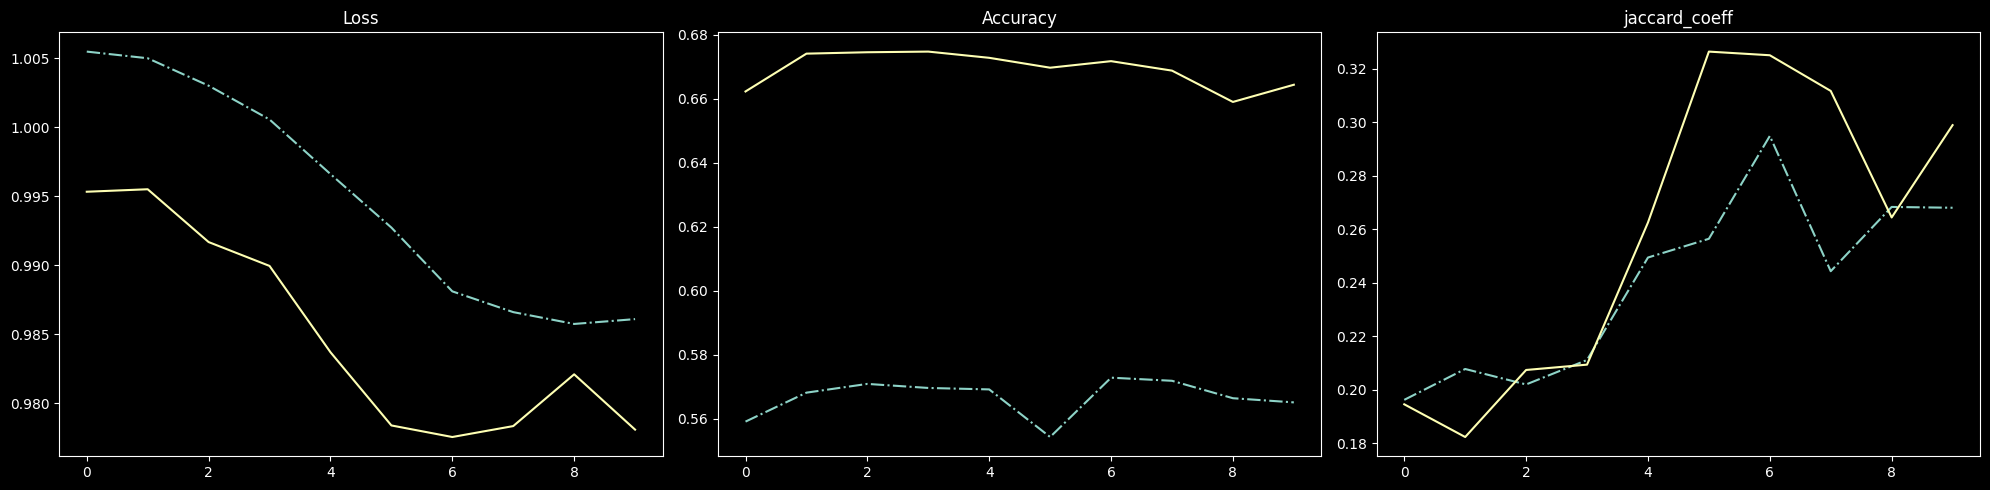

In [61]:
fg, ax = plt.subplots( 1,3, figsize= (20,5)  )

ax[0].plot( kModelHist.history['loss'], '-.' )
ax[0].plot( kModelHist.history['val_loss'] )
ax[0].set_title('Loss')

ax[1].plot( kModelHist.history['accuracy'], '-.' )
ax[1].plot( kModelHist.history['val_accuracy'] )
ax[1].set_title('Accuracy')

ax[2].plot( kModelHist.history['jaccard_coef'], '-.' )
ax[2].plot( kModelHist.history['val_jaccard_coef'] )
ax[2].set_title('jaccard_coeff')

fg.tight_layout()

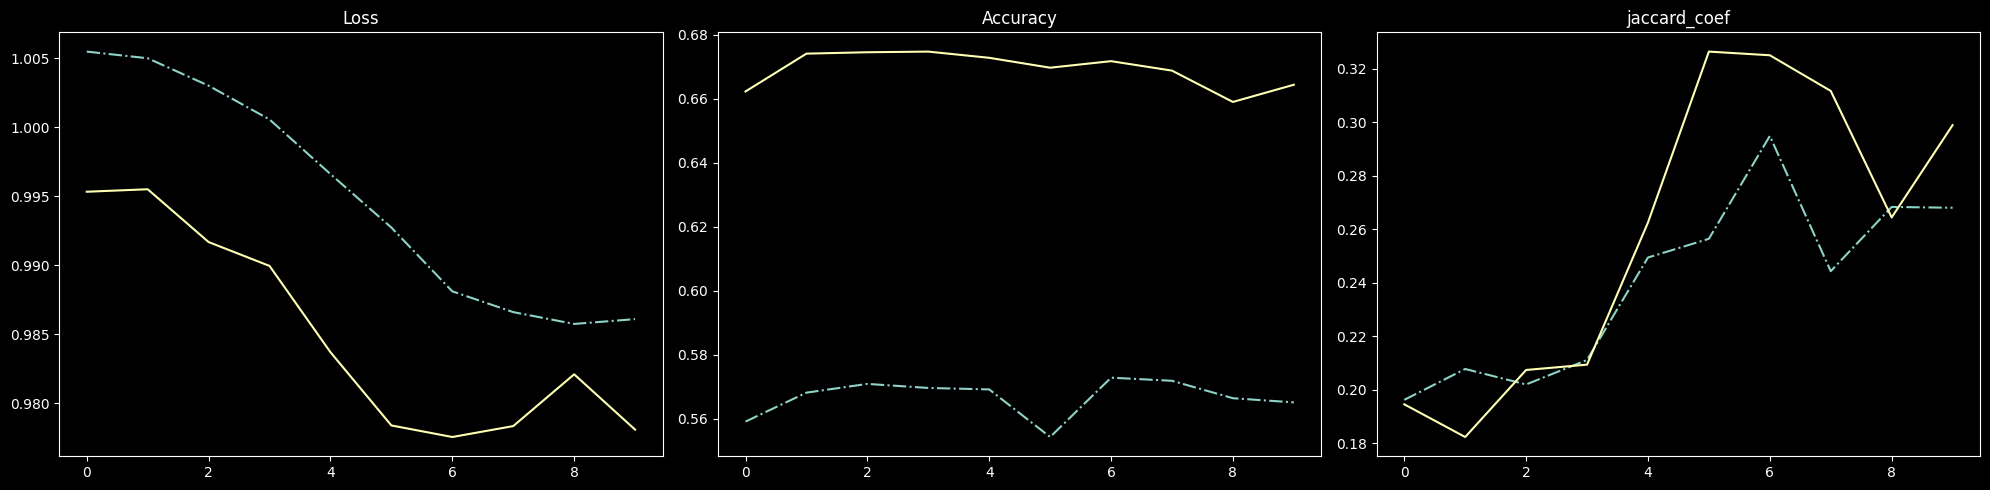

In [62]:
fg, ax = plt.subplots( 1,3, figsize= (20,5)  )

ax[0].plot( kModelHist.history['loss'], '-.' )
ax[0].plot( kModelHist.history['val_loss'] )
ax[0].set_title('Loss')

ax[1].plot( kModelHist.history['accuracy'], '-.' )
ax[1].plot( kModelHist.history['val_accuracy'] )
ax[1].set_title('Accuracy')

ax[2].plot( kModelHist.history['jaccard_coef'], '-.' )
ax[2].plot( kModelHist.history['val_jaccard_coef'] )
ax[2].set_title('jaccard_coef')

fg.tight_layout()

	
###  Callback using Class approach


In [63]:
import IPython

class PlotLossEx(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []

    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)

    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    plt.figure(figsize=(14,8))
    f, (graph1, graph2) = plt.subplots(1,2, sharex=True)
    
    IPython.display.clear_output(wait=True)

    graph1.set_yscale('log')
    graph1.plot(self.x, self.losses, label="loss")
    graph1.plot(self.x, self.val_losses, label="val_loss")
    graph1.legend()

    graph2.set_yscale('log')
    graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")
    graph2.legend()

    plt.tight_layout(); plt.show();

plotLoss_obj = PlotLossEx()

<Figure size 1400x800 with 0 Axes>

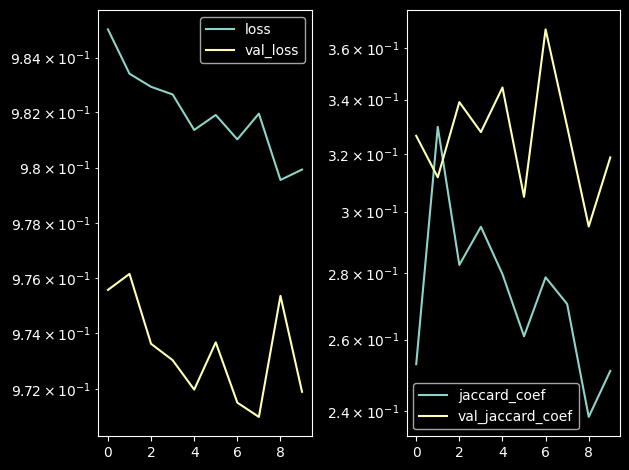

7/7 - 1s - loss: 0.9799 - accuracy: 0.5835 - jaccard_coef: 0.2511 - val_loss: 0.9719 - val_accuracy: 0.7219 - val_jaccard_coef: 0.3187 - 1s/epoch - 146ms/step


In [64]:
kModelHist2 = kerasModel1.fit(  xtrn, ytrn, batch_size= 10, verbose= 2, epochs= 10, validation_data= (xtst,ytst),
                               callbacks= [ plotLoss_obj ]   )

###  Prediction

In [65]:
yhat = kerasModel1.predict( x= xtst, verbose= 2 )

1/1 - 2s - 2s/epoch - 2s/step


In [66]:
yhat.shape, ytst.shape

((11, 256, 256, 6), (11, 256, 256, 6))

In [67]:
_ytst = np.argmax( ytst, axis= -1 )
_yhat = np.argmax( yhat, axis= -1 )
         
print(  _ytst.shape, _yhat.shape )

(11, 256, 256) (11, 256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


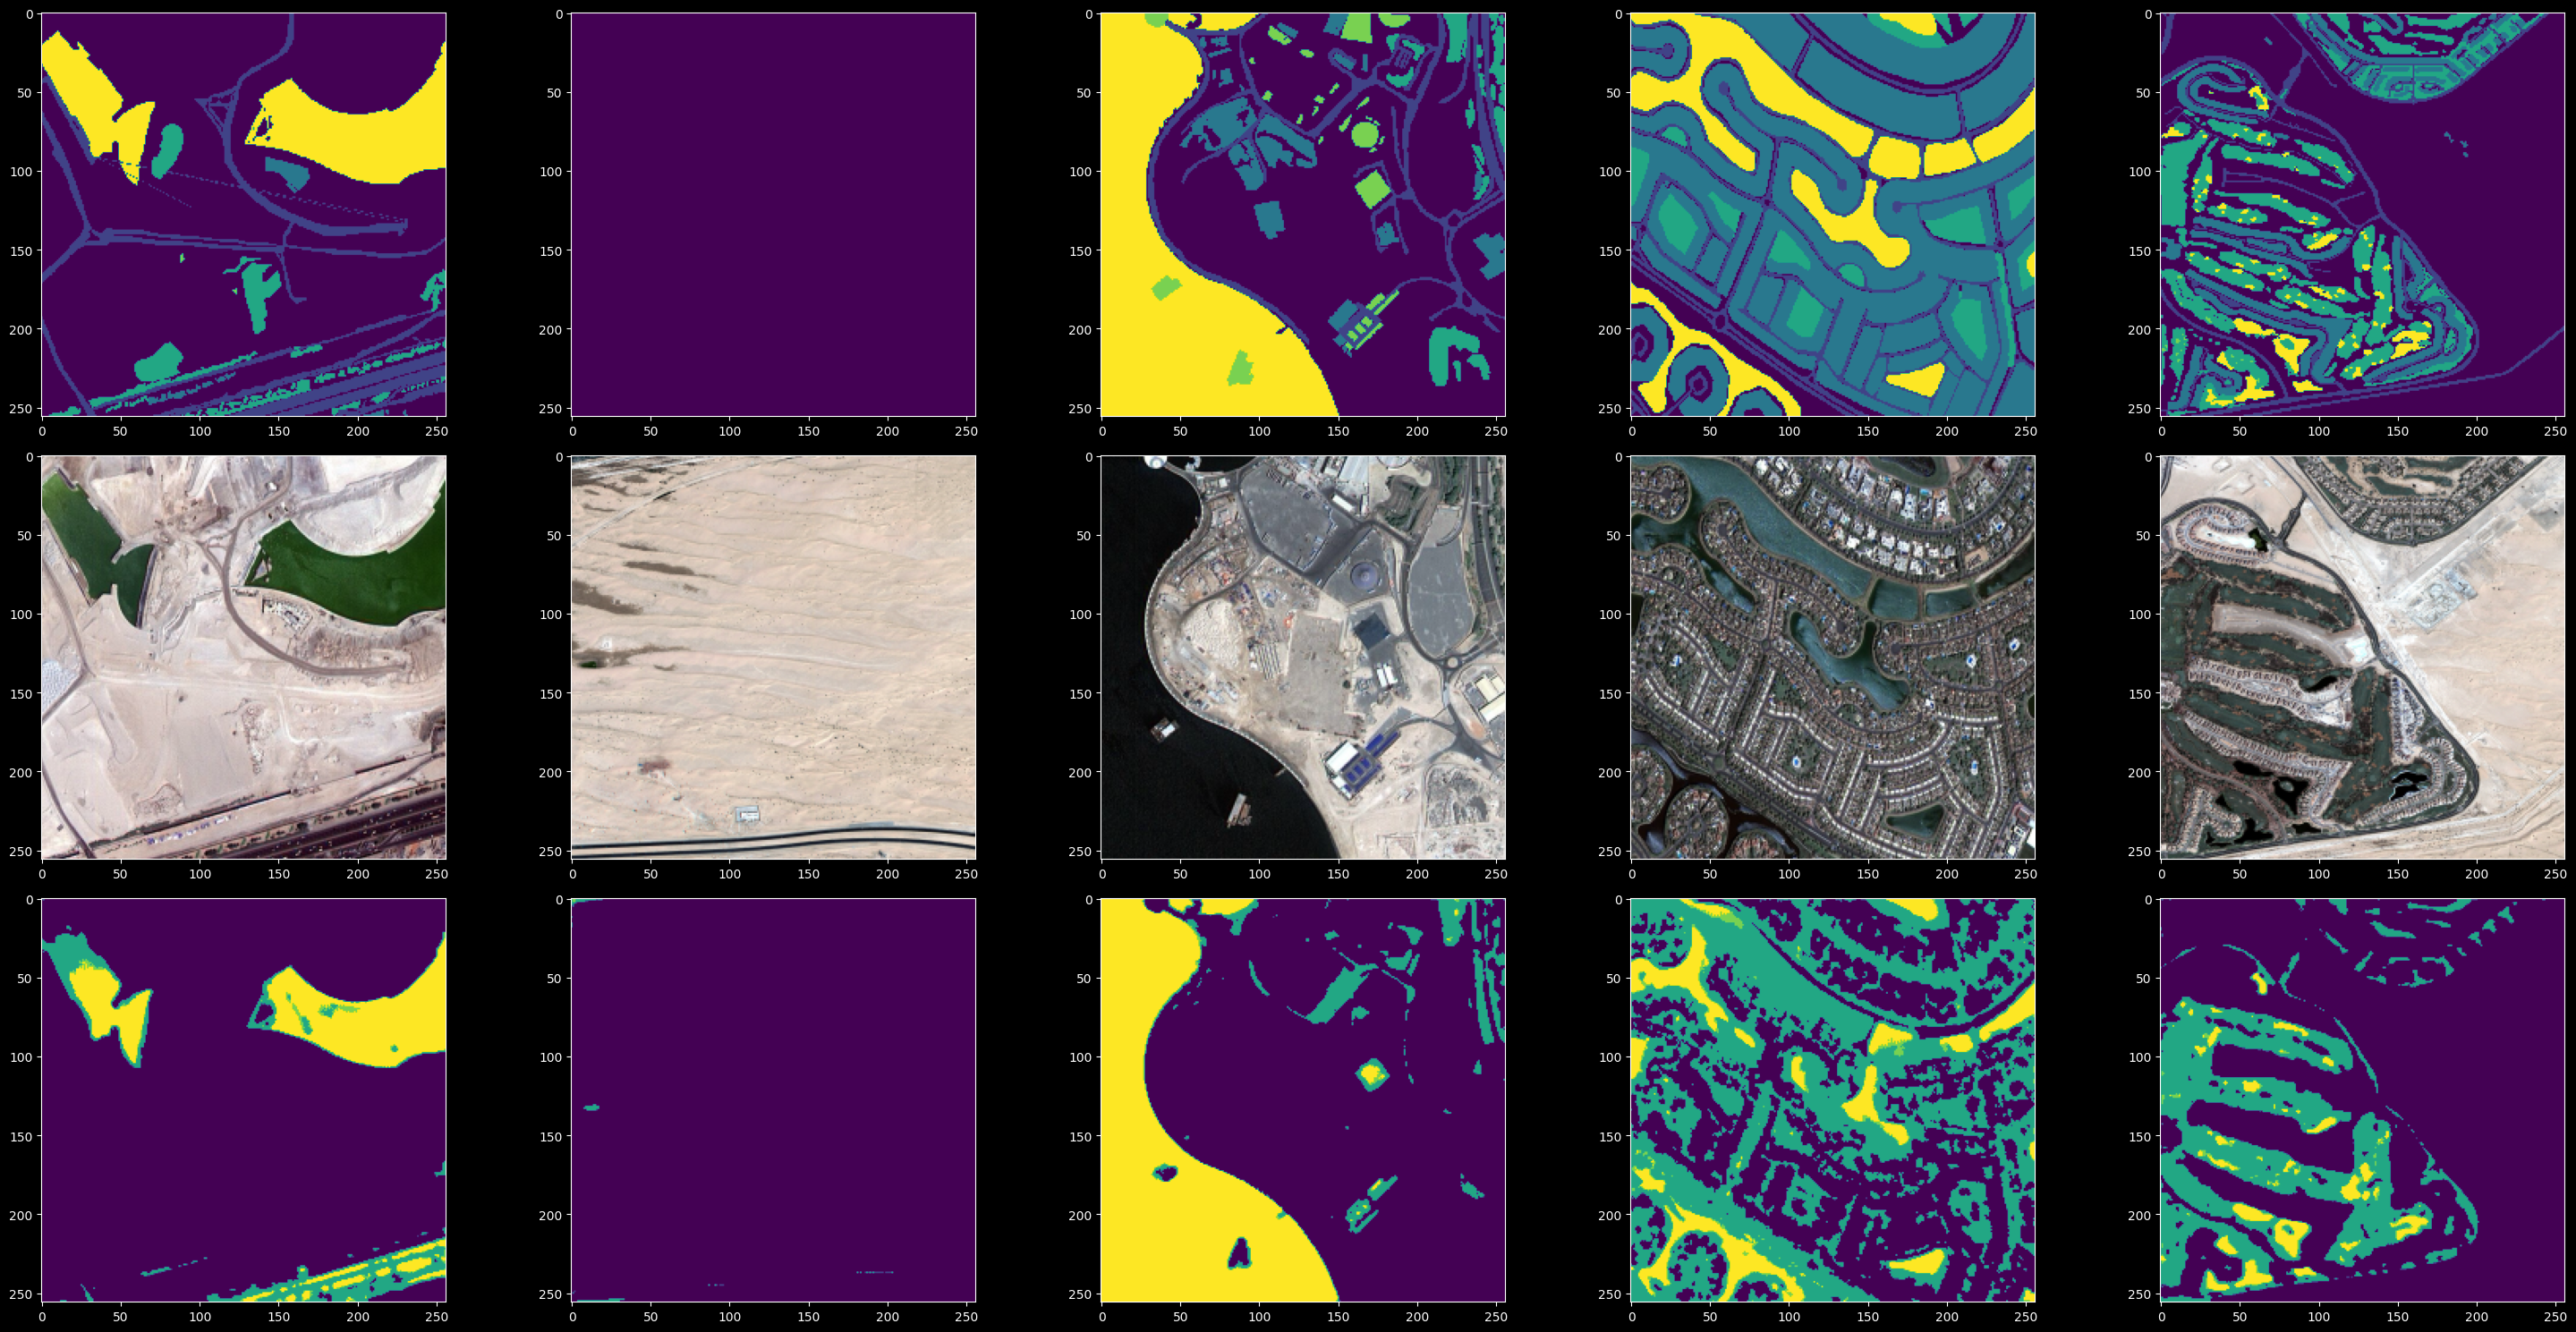

In [68]:
# plt.imshow( _yhat[0] )
row_num = 3; col_num = 5
fg, ax = plt.subplots(  row_num,col_num, figsize= ( 30, 15 )  )
imgIdx_ls = [ 5,6,7,8,9 ]

for e_imgIdx, ecol in zip( imgIdx_ls,range(col_num) ):
    ax[0][ecol].imshow( _ytst[e_imgIdx] )
    ax[1][ecol].imshow(  xtst[e_imgIdx] )
    ax[2][ecol].imshow( _yhat[e_imgIdx] )
    
fg.tight_layout()

<div id= '1.2.5></div>
	
### 1.2.5 - Observing Activations over the Convolution layers


*[Go to top](#toc)*

In [69]:
kerasModel1.loss.name

'dice_loss_plus_1focal_loss'

In [70]:
## load model
# kerasModel1_saved = keras.models.load_model( 'sat-segm-model1.h5' )

NameError: name 'kerasModel1' is not defined

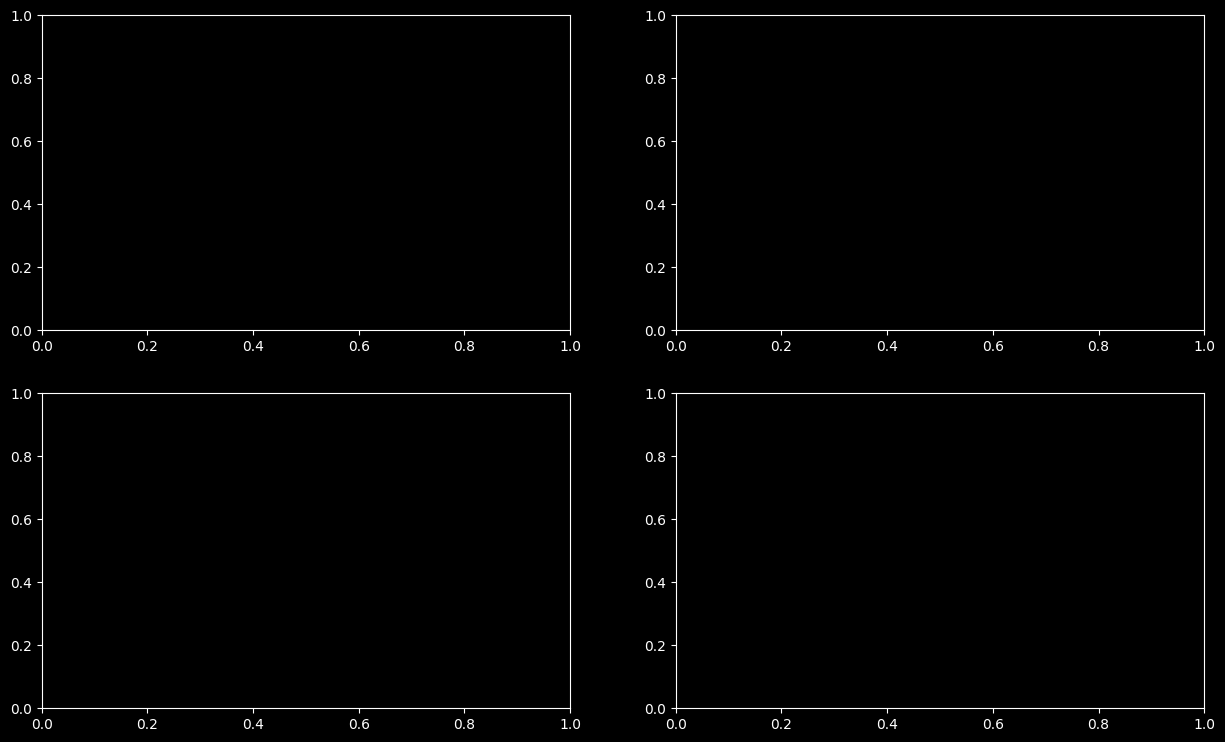

In [27]:
fg, ax= plt.subplots( 2,2, figsize= (15,9) )

yhat7 = kerasModel1.predict(  np.expand_dims(xtst[7],0), verbose= 0  )
yhat7 = np.argmax( yhat7, axis= 3 )[0,:,:]
			
yhat9 = kerasModel1.predict(  np.expand_dims(xtst[9],0), verbose= 0  )
yhat9 = np.argmax( yhat9, axis= 3 )[0,:,:]

ax[0][0].imshow(  xtst[7] );    ax[0][1].imshow(  yhat7 );
ax[1][0].imshow(  xtst[9] );    ax[1][1].imshow(  yhat9 );


### Observing Activations over the Convolution layers

In [ ]:
modelAct1 = kact.get_activations( model= kerasModel1, x= np.expand_dims(xtst[7],0),
                                  nodes_to_evaluate= None, output_format= 'simple', auto_compile= True )


In [ ]:
print( len(modelAct1) )
list( modelAct1.keys() )[:10]

41


['input_2',
 'conv2d_19',
 'dropout_9',
 'conv2d_20',
 'max_pooling2d_4',
 'conv2d_21',
 'dropout_10',
 'conv2d_22',
 'max_pooling2d_5',
 'conv2d_23']

In [ ]:
## save the model locally
kact.display_activations(  activations= modelAct1, cmap= 'viridis', save= True, directory= r'datasets/kerasActivationFiles_Unet'  )

input_2 (1, 256, 256, 3) 
conv2d_19 (1, 256, 256, 16) 
dropout_9 (1, 256, 256, 16) 
conv2d_20 (1, 256, 256, 16) 
max_pooling2d_4 (1, 128, 128, 16) 
conv2d_21 (1, 128, 128, 32) 
dropout_10 (1, 128, 128, 32) 
conv2d_22 (1, 128, 128, 32) 
max_pooling2d_5 (1, 64, 64, 32) 
conv2d_23 (1, 64, 64, 64) 
dropout_11 (1, 64, 64, 64) 
conv2d_24 (1, 64, 64, 64) 
max_pooling2d_6 (1, 32, 32, 64) 
conv2d_25 (1, 32, 32, 128) 
dropout_12 (1, 32, 32, 128) 
conv2d_26 (1, 32, 32, 128) 
max_pooling2d_7 (1, 16, 16, 128) 
conv2d_27 (1, 16, 16, 256) 
dropout_13 (1, 16, 16, 256) 
conv2d_28 (1, 16, 16, 256) 
conv2d_transpose_4 (1, 32, 32, 128) 
concatenate_4 (1, 32, 32, 256) 
conv2d_29 (1, 32, 32, 128) 
dropout_14 (1, 32, 32, 128) 
conv2d_30 (1, 32, 32, 128) 
conv2d_transpose_5 (1, 64, 64, 64) 
concatenate_5 (1, 64, 64, 128) 
conv2d_31 (1, 64, 64, 64) 
dropout_15 (1, 64, 64, 64) 
conv2d_32 (1, 64, 64, 64) 
conv2d_transpose_6 (1, 128, 128, 32) 
concatenate_6 (1, 128, 128, 64) 
conv2d_33 (1, 128, 128, 32) 
dropout_

In [ ]:
modelAct1.keys()

model_ConvAct = dict(    filter(   lambda eitem: eitem[0].startswith( 'conv' ), modelAct1.items()   )    )
print(  model_ConvAct.keys()  )
model_ConvAct = list( model_ConvAct.items() )

dict_keys(['conv2d_19', 'conv2d_20', 'conv2d_21', 'conv2d_22', 'conv2d_23', 'conv2d_24', 'conv2d_25', 'conv2d_26', 'conv2d_27', 'conv2d_28', 'conv2d_transpose_4', 'conv2d_29', 'conv2d_30', 'conv2d_transpose_5', 'conv2d_31', 'conv2d_32', 'conv2d_transpose_6', 'conv2d_33', 'conv2d_34', 'conv2d_transpose_7', 'conv2d_35', 'conv2d_36', 'conv2d_37'])


In [ ]:
## read the saved act img
import glob
actImg_rootDir = pathlib.Path( os.path.join( os.getcwd(), 'datasets/kerasActivationFiles_Unet' )  )
imgPath_ls =  [  str(efile) for efile in actImg_rootDir.rglob( '*.png' ) if 'conv' in efile.name ]

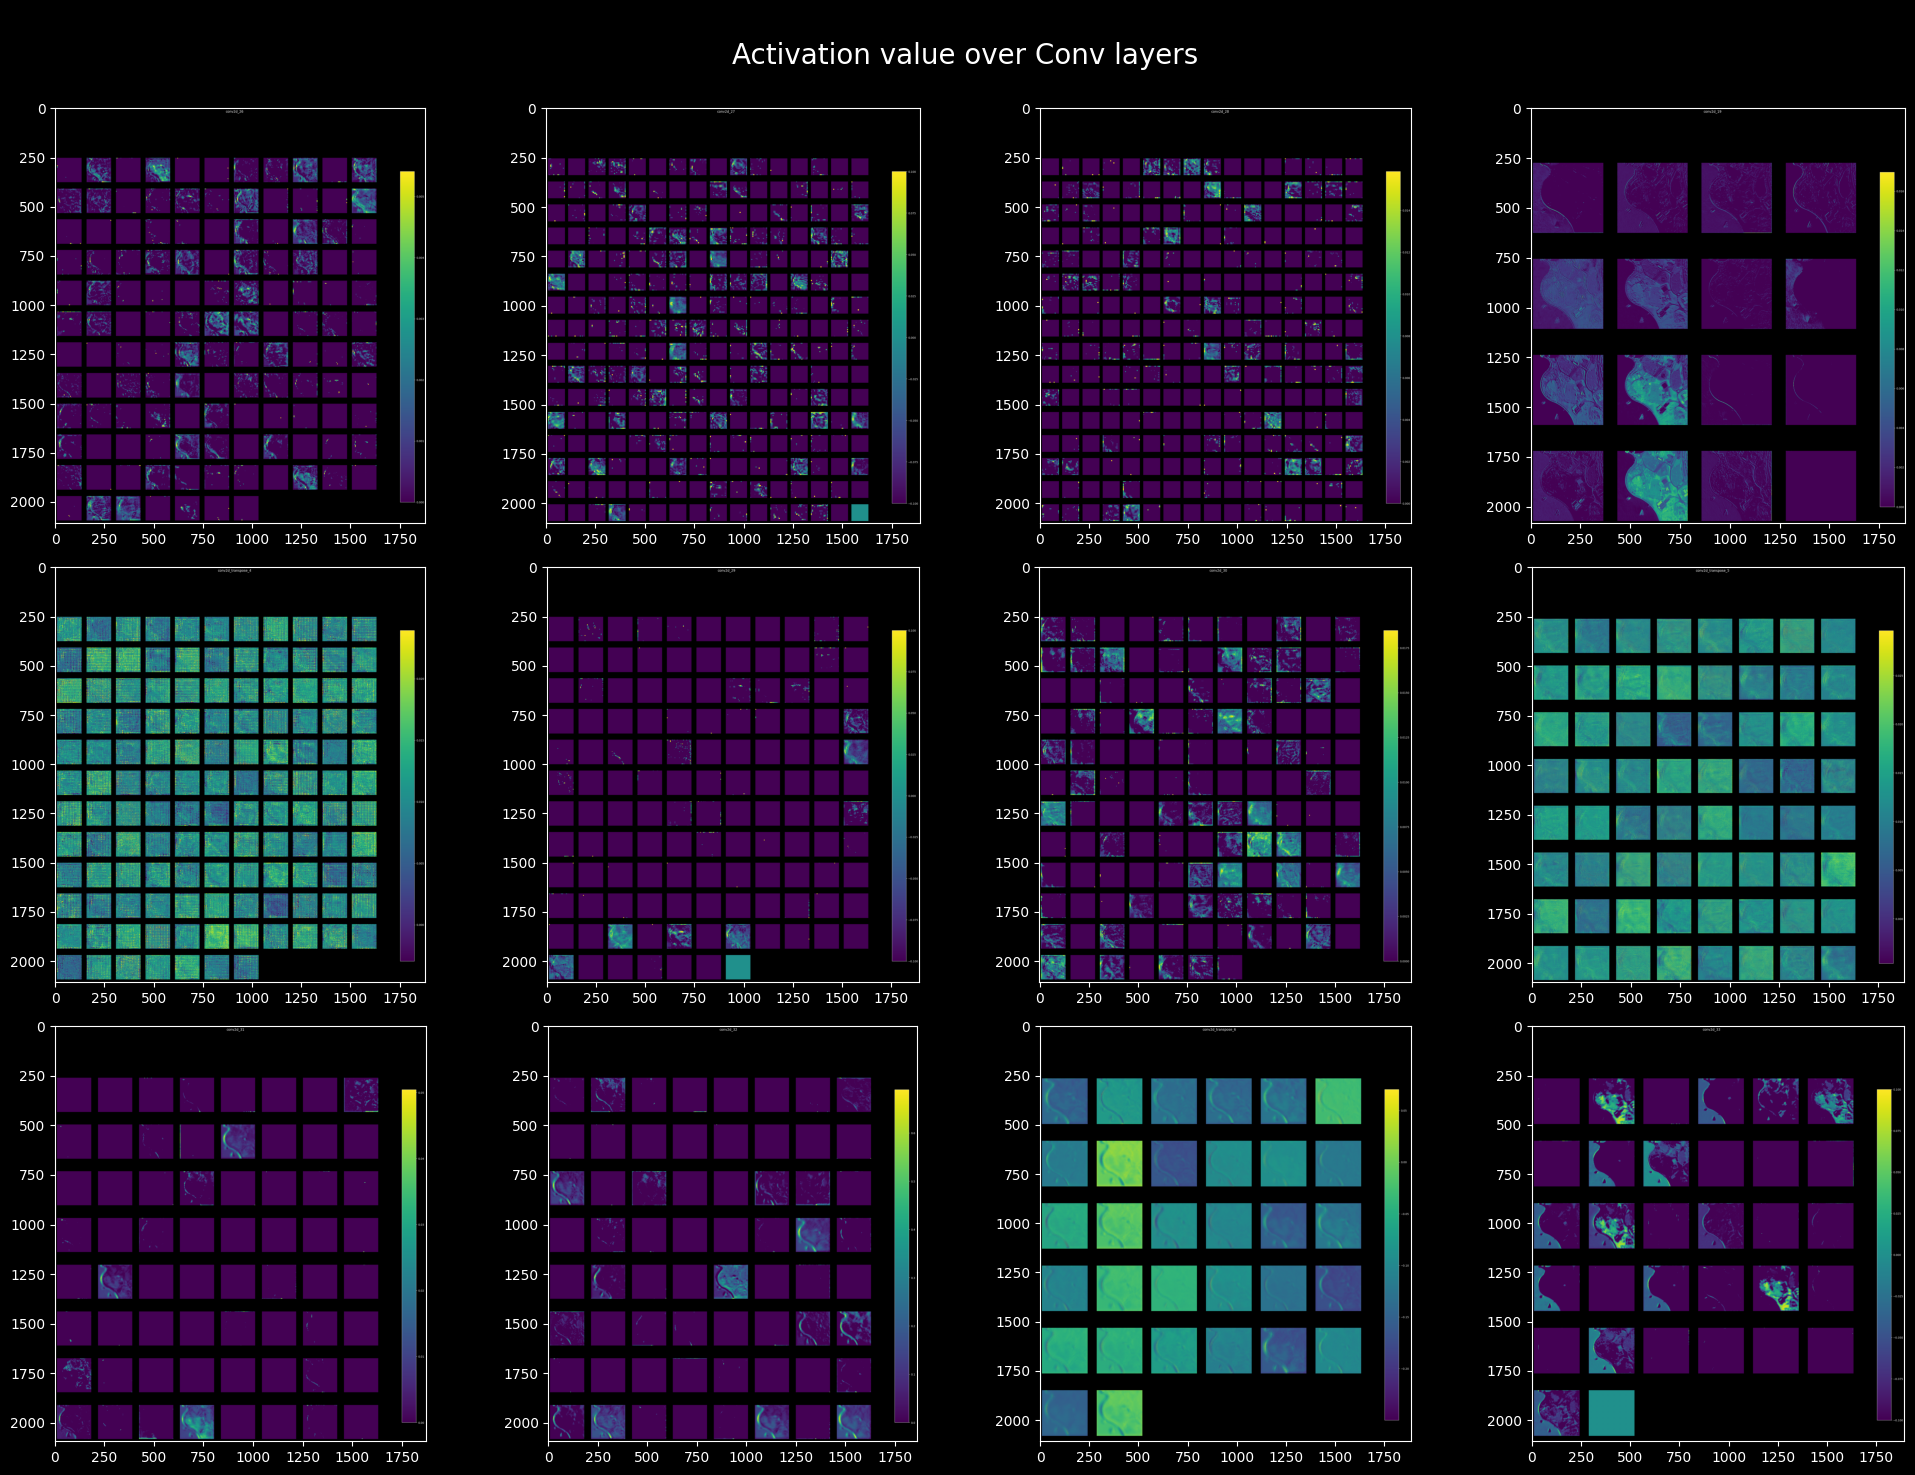

In [ ]:
fg, ax = plt.subplots(  3,4, figsize= (20,15)  )

for idx, eax in enumerate( ax.flatten() ):
	eax.imshow(  pil.Image.open( imgPath_ls[idx+2] )  )
fg.suptitle( '\nActivation value over Conv layers\n', fontsize= 20 )
plt.tight_layout()